In [1]:
!pip install torchinfo
!pip install fastwer

  Preparing metadata (setup.py) ... done
  Created wheel for fastwer: filename=fastwer-0.1.3-cp311-cp311-linux_x86_64.whl size=866377 sha256=8614eaf236e2c16bc68674b7ea754ce1ecdd442f7e28b258dc915795cb566b67
  Stored in directory: /root/.cache/pip/wheels/4c/53/1e/8d806da8c1ed1de60e371005658af32b92aad9426b37208f1f
Successfully built fastwer


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import os
import fastwer
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
os.listdir('/kaggle/input/')

['Vietnam']

In [4]:
val_word_data = pd.read_csv('/kaggle/input/Vietnam/validation_word.csv', sep='\t', index_col=0)
train_word_data = pd.read_csv('/kaggle/input/Vietnam/train_word.csv', sep='\t', index_col=0)
test_word_data = pd.read_csv('/kaggle/input/Vietnam/test_word.csv', sep='\t', index_col=0)

In [5]:
train_word_data.head()

,id,label
0,20140603_0003_BCCTC_tg_0_0_0,Bản
1,20140603_0003_BCCTC_tg_0_0_1,chất
2,20140603_0003_BCCTC_tg_0_0_2,của
3,20140603_0003_BCCTC_tg_0_0_3,thành
4,20140603_0003_BCCTC_tg_0_0_4,công


In [6]:
class Vocab():
    def __init__(self, chars):
        self.pad = 0
        self.go = 1
        self.eos = 2
        self.mask_token = 3

        self.chars = chars

        self.c2i = {c:i+4 for i, c in enumerate(chars)}

        self.i2c = {i+4:c for i, c in enumerate(chars)}

        self.i2c[0] = '<pad>'
        self.i2c[1] = '<sos>'
        self.i2c[2] = '<eos>'
        self.i2c[3] = '*'

    def encode(self, chars):
        return [self.go] + [self.c2i[c] for c in chars] + [self.eos]

    def decode(self, ids):
        if isinstance(ids, np.ndarray):
          ids = ids.tolist()
        filtered_ids = [i for i in ids if i > 3 and i in self.i2c]
        
        if self.eos in ids:
            eos_index = ids.index(self.eos)
            filtered_ids = [i for i in ids[:eos_index] if i > 3 and i in self.i2c]

        sent = ''.join([self.i2c[i] for i in filtered_ids])
        return sent

    def __len__(self):
        return len(self.c2i) + 4

    def batch_decode(self, arr):
        texts = [self.decode(ids) for ids in arr]
        return texts

    def __str__(self):
        return self.chars

In [7]:
# Tạp kí tự
vocab = Vocab('aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ')
# char2idx = {char : idx for idx, char in enumerate(vocab)}
# idx2char = {idx: char for idx, char in enumerate(vocab)}
vocab_size = vocab.__len__()
vocab.__str__()

'aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ '

## **preprocessing image**

In [8]:
def process(img_path):
    img = cv2.imread(img_path, 0) 
    if img is None:
        return None
    kernel = np.ones((5, 5), np.uint8)
 
    image = cv2.GaussianBlur(img, (5, 5), 0)
    
 
    image = cv2.adaptiveThreshold(
        image, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        11, 5
    )
 
    kernel = np.ones((11, 11), np.uint8)
    img_erosion = cv2.erode(image, kernel, iterations=1)
    
    return img_erosion

In [9]:
widths= []
heights = []
def preprocess_image(image_path, label_len, img_h=64, char_w=32):
    valid_img = True
    img = process(image_path)

    try:
        cur_h, cur_w = img.shape
        modified_w = int(cur_w * (img_h / cur_h))

        # Kiểm tra tỷ lệ hợp lệ giữa độ rộng ảnh và độ dài nhãn
        if ((modified_w / label_len) < (char_w / 4)) or ((modified_w / label_len) > (4 * char_w)):
            valid_img = False
        else:
            img_w = label_len * char_w
            img = cv2.resize(img, (img_w, img_h), interpolation=cv2.INTER_AREA)

    except AttributeError:
        valid_img = False

    if not valid_img:
        return None

    # Thêm chiều kênh (từ HxW → 1xHxW)
    img = np.expand_dims(img, axis=0)

    # Chuẩn hóa giá trị pixel về [0,1]
    img = img / 255.0

    return torch.tensor(img, dtype=torch.float32)

In [10]:
class HandwrittenDataset(Dataset):
    def __init__(self, data, image_dir, vocab, data_type='generic'):
        # loại bỏ các dòng trong data có label rỗng/ NaN
        self.data = data.dropna(subset=['label'])
        self.data = self.data[self.data['label'].str.strip() != '']
        self.image_dir = image_dir
        self.vocab = vocab
        self.data_type = data_type

    def __len__(self):
        return len(self.data) # số lượng sample trong data

    def clean_text(self, text):
        # ký tự ko có trong vocab thì bỏ
        allowed_chars = set(self.vocab.c2i.keys())  # Set các ký tự hợp lệ từ vocab
        return ''.join([char if char in allowed_chars else '' for char in text])  # Loại bỏ ký tự không có trong vocab

    def encode_to_labels(self, label, max_length=None):
        label = self.clean_text(label)  # bỏ mấy kí tự ko trong vocab
        label_indices = self.vocab.encode(label)

        if max_length is not None and len(label_indices) < max_length:
            label_indices = label_indices + [self.vocab.pad] * (max_length - len(label_indices))

        return label_indices # kí tự sang chuỗi số (list[int])

    def __getitem__(self, idx): # lấy img và label tương ứng idx

        img_id = self.data.iloc[idx]['id']
        label = self.data.iloc[idx]['label']

        label_len = len(label)
    
        image_path = os.path.join(self.image_dir, f"{img_id}.png")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Không tìm thấy tệp: {image_path}")

        image = preprocess_image(image_path, label_len)
        if image == None:
            return self.__getitem__((idx + 1) % len(self))
        else:
            label_indices = self.encode_to_labels(label, max_length=None)
            label_tensor = torch.tensor(label_indices, dtype=torch.long)
    
            label_length = len(label_indices) # len nhưng mà là len của tensor
    
            # length: có padding
            # len: ko có
            return image, label_tensor, label_length, label_len # ký tự nhãn -> tensor

    def show_samples(self, idx=None): #in mẫu coi chơi
        plt.figure(figsize=(15, 5))

        if idx is None:
            idx = np.random.randint(0, len(self))

        image, label_tensor,_, label_len = self[idx]

        image = image.squeeze(0).numpy()
        image = (image * 255).astype(np.uint8)

        decoded_label = self.vocab.decode(label_tensor.tolist())
        print(f"Label_length: {label_len}")

        print(f"Encoded Label: {label_tensor}")
        print(f"Decoded Label: {decoded_label}")
        print(f"Image Shape: {image.shape}")
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.show()



In [11]:
def handwritten_collate_fn(batch):
    # các ảnh trong batch dạng tensor
    # label của mấy ảnh đó cx dạng tensor
    images, labels, label_lengths, label_lens = zip(*batch)

    # chìu dài tối đa của toàn bộ labels trong batch (tính trên số kí tự)

    #chìu rộng lớn của toàn bộ ảnh trogn 1 batch
    max_width = max(img.shape[2] for img in images)
    
    # padding ảnh về cùng width
    padded_images = []
    for img in images:
        _, h, w = img.shape
        if w < max_width:
            pad_size = max_width - w
            padding = torch.full((1, h, pad_size), fill_value=1.0)  # Padding bằng 1 (giả sử nền trắng)
            padded_img = torch.cat([img, padding], dim=2)
        else:
            padded_img = img
        padded_images.append(padded_img)
        
    images_tensor = torch.stack(padded_images)

    max_label_length = max(label_lengths)
    # padding cho mấy cái label có cùng độ dài
    labels_padded = torch.zeros(len(labels), max_label_length, dtype=torch.long)
    for i, label in enumerate(labels):
        labels_padded[i, :label_lengths[i]] = label

    label_lengths_tensor = torch.tensor(label_lengths, dtype=torch.long)

    return images_tensor, labels_padded, label_lengths_tensor

In [12]:
# Tạo dataset cho từng bộ dữ liệu
word_train_dataset = HandwrittenDataset(train_word_data, '/kaggle/input/Vietnam/train_word', vocab)
word_val_dataset = HandwrittenDataset(val_word_data, '/kaggle/input/Vietnam/validation_word', vocab)
word_test_dataset = HandwrittenDataset(test_word_data, '/kaggle/input/Vietnam/test_word', vocab)

Label_length: 3
Encoded Label: tensor([  1,  40,   4, 100,   2])
Decoded Label: bao
Image Shape: (64, 96)


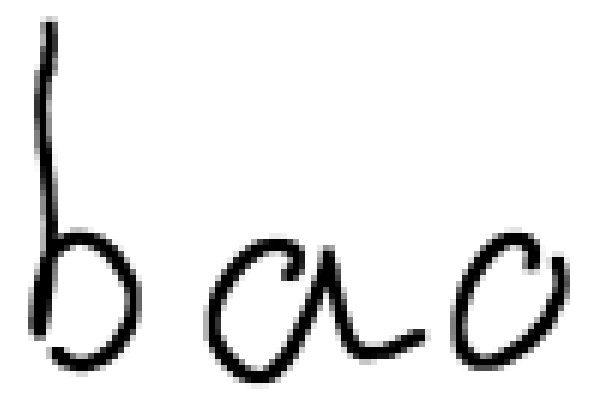

Label_length: 3
Encoded Label: tensor([  1,  74,  78, 126,   2])
Decoded Label: giờ
Image Shape: (64, 96)


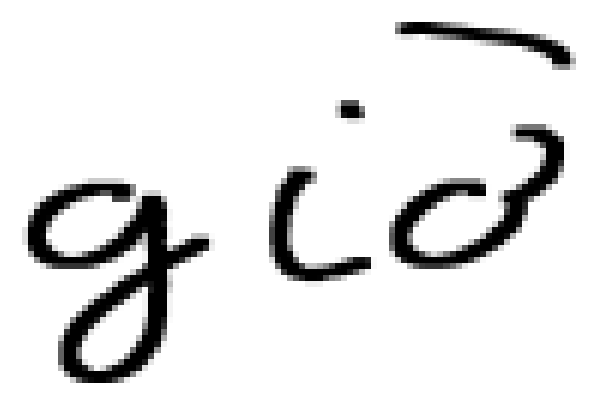

In [13]:
word_train_dataset.show_samples(6)
word_train_dataset.show_samples(7)

In [14]:
train_loader = DataLoader(word_train_dataset, batch_size=16, shuffle=True, collate_fn=handwritten_collate_fn, num_workers=4, pin_memory=True)
val_loader = DataLoader(word_val_dataset, batch_size=16, shuffle=True, collate_fn=handwritten_collate_fn, num_workers=4, pin_memory=True)
test_loader = DataLoader(word_test_dataset, batch_size=16, shuffle=True, collate_fn=handwritten_collate_fn, num_workers=4, pin_memory=True)

Images Shape: torch.Size([16, 1, 64, 128])
Labels Padded Shape: torch.Size([16, 6])
Label Lengths: tensor([5, 4, 5, 6, 6, 4, 4, 6, 5, 5, 5, 6, 6, 4, 5, 6])


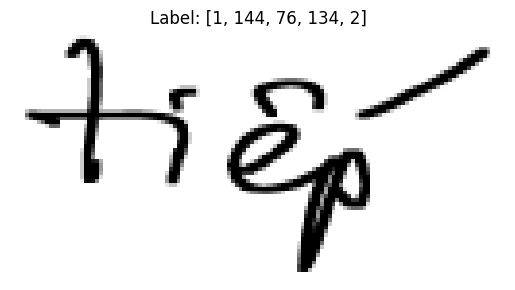

In [15]:
#Lấy một batch từ DataLoader
i = 0
for images, labels_padded, label_lengths in train_loader:
    i += 1
    if i == 3:
        print("Images Shape:", images.shape)  # (batch_size, 1, 256, 512)
        print("Labels Padded Shape:", labels_padded.shape)  # (batch_size, max_label_length)
        print("Label Lengths:", label_lengths)  # (batch_size,)
    
        # Lấy ảnh đầu tiên từ batch
        first_image = images[3].squeeze(0).numpy()  # Loại bỏ kênh chiều 1
    
        # Hiển thị ảnh
        plt.imshow(first_image, cmap='gray')
        plt.title(f"Label: {labels_padded[0][:label_lengths[0]].tolist()}")
        plt.axis('off')  # Tắt các trục
        plt.show()
    
        break


In [16]:
# # Kiểm tra từng bộ dữ liệu bằng cách hiển thị một số mẫu
# print("Line Dataset Sample:")
# line_dataset.show_samples(0)

# print("Word Dataset Sample:")
# word_dataset.show_samples(0)

# print("Paragraph Dataset Sample:")
# para_dataset.show_samples(0)

## **Calculate CER and WER**

In [17]:
import editdistance

In [18]:
def cal_cer(predicted, target):
  predicted_text = predicted.replace(' ','')
  target_text = target.replace(' ','')
  cer = editdistance.eval(predicted_text, target_text) / float(max(len(predicted_text), len(target_text)))
  return cer

In [19]:
def cal_wer(predicted, target):
  predicted_words = predicted.split()
  target_words = target.split()
  wer = editdistance.eval(predicted_words, target_words) / float(max(len(predicted_words), len(target_words)))
  return wer

## **Eval function**

In [20]:
def evaluate(model, dataloader, vocab, device):
    model.eval()
    total_cer = 0
    total_wer = 0
    total_correct_chars = 0  # tổng số ký tự đúng
    total_chars = 0          # tổng số ký tự thực
    sample_count = 0

    with torch.no_grad():
        for images, labels_padded, label_lengths in dataloader:
            images = images.to(device)
            labels_padded = labels_padded.to(device)

            # Forward
            outputs = model(images)  # (seq_len, batch, vocab_size)
            log_probs = F.log_softmax(outputs, dim=2)

            predicted_indices = log_probs.argmax(dim=2)  # (seq_len, batch)
            predicted_texts = vocab.batch_decode(predicted_indices.T.cpu().numpy())

            labels_padded_np = labels_padded.cpu().numpy()
            label_lengths_np = label_lengths.cpu().numpy()

            # Giải mã nhãn thật
            target_texts = []
            for i in range(len(labels_padded_np)):
                unpadded = labels_padded_np[i][:label_lengths_np[i]]
                decoded = vocab.decode(unpadded)
                target_texts.append(decoded)

            for i, (pred, target) in enumerate(zip(predicted_texts, target_texts)):
                if not pred or not target: 
                    continue
                pred = pred.replace('*', '')

                if sample_count < 5:
                    print(f"Predicted: {repr(pred)}")
                    print(f"Target:    {repr(target)}")

                sample_count += 1
                    

                total_cer += fastwer.score_sent(pred, target, char_level=True)/100
                total_wer += fastwer.score_sent(pred, target, char_level=False)/100

                # Tính accuracy theo ký tự
                min_len = min(len(pred), len(target))
                correct = sum(1 for a, b in zip(pred[:min_len], target[:min_len]) if a == b)
                total_correct_chars += correct
                total_chars += len(target)

    avg_cer = total_cer / sample_count
    avg_wer = total_wer / sample_count
    avg_char_acc = total_correct_chars / total_chars if total_chars > 0 else 0.0

    return avg_cer, avg_wer, avg_char_acc


## **Build model**

### 5l cnn, 3l lstm, linear

In [21]:
import torch.nn as nn

class CRNN_LSTM_Lite(nn.Module):
    def __init__(self, vocab_size, img_channels=1, lstm_hidden=256):
        super(CRNN_LSTM_Lite, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # h/2
            nn.Dropout(0.1),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2), #h/4
            nn.Dropout(0.1),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2), #h/8
            nn.Dropout(0.1),

            nn.Conv2d(256, 256, kernel_size=3, stride=(2,2), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(), 
            nn.Dropout(0.1), #h/16

            nn.Conv2d(256, 512, kernel_size=3, stride=(2,1), padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.1),#h/32

            nn.Conv2d(512, 512, kernel_size=3,  stride=(2,1), padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.2) #h/64
        )

        # Tính kích thước đầu vào LSTM từ chiều cao ảnh đầu vào (ví dụ: H=64)
        self.feature_h = 64 // 64  # chiều cao còn lại sau pooling

        self.lstm = nn.LSTM(
            input_size=512 * self.feature_h,
            hidden_size=lstm_hidden,
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )

        self.dropout = nn.Dropout(0.3)

        self.classifier = nn.Linear(lstm_hidden *2 , vocab_size)

    def forward(self, x):
        batch_size = x.size(0)
        features = self.cnn(x)  # (B, 512, H/8, W/4)

        # (B, C, H, W) -> (B, W, C*H)
        b, c, h, w = features.size()
        features = features.permute(0, 3, 1, 2)  # (B, W, C, H)
        features = features.contiguous().view(b, w, c * h)  # (B, W, C*H)

        lstm_out = self.lstm(features)[0]  # (B, W, 2*hidden)
        lstm_out = self.dropout(lstm_out)
        output = self.classifier(lstm_out)  # (B, W, vocab_size)
        output = output.permute(1, 0, 2)  # (seq_len, batch, vocab_size) cho CTC Loss

        return output


In [22]:
# import torch
# import torch.nn as nn

# class ResidualBlock(nn.Module):
#     def __init__(self, channels):
#         super().__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(channels, channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(channels),
#             nn.ReLU(),
#             nn.Conv2d(channels, channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(channels)
#         )
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         return self.relu(self.conv(x) + x)

# class CRNN_LSTM_Improved(nn.Module):
#     def __init__(self, vocab_size, img_channels=1, lstm_hidden=256):
#         super().__init__()

#         self.cnn = nn.Sequential(
#             nn.Conv2d(img_channels, 64, kernel_size=3, padding=1),  # (B, 64, 64, W)
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2),  # -> (B, 64, 32, W/2)
#             nn.Dropout(0.1),

#             nn.Conv2d(64, 128, kernel_size=3, padding=1),           # -> (B, 128, 32, W/2)
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2),                                      # -> (B, 128, 16, W/4)
#             nn.Dropout(0.1),

#             nn.Conv2d(128, 256, kernel_size=3, padding=1),          # -> (B, 256, 16, W/4)
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             ResidualBlock(256),                                     # Residual connection
#             nn.Dropout(0.1),

#             nn.Conv2d(256, 256, kernel_size=3, stride=(2,1), padding=1),  # -> (B, 256, 8, W/4)
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.Dropout(0.1),

#             nn.Conv2d(256, 512, kernel_size=3, padding=1),          # -> (B, 512, 8, W/4)
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.AdaptiveAvgPool2d((8, None)),  # fix H = 8 regardless of input
#             nn.Dropout(0.2)
#         )

#         self.feature_h = 8
#         self.ln = nn.LayerNorm(512 * self.feature_h)

#         self.lstm = nn.LSTM(
#             input_size=512 * self.feature_h,
#             hidden_size=lstm_hidden,
#             num_layers=2,
#             bidirectional=True,
#             batch_first=True
#         )

#         self.dropout = nn.Dropout(0.3)
#         self.classifier = nn.Linear(lstm_hidden * 2, vocab_size)

#     def forward(self, x):
#         features = self.cnn(x)  # (B, 512, 8, W')
#         b, c, h, w = features.size()
#         features = features.permute(0, 3, 1, 2).contiguous().view(b, w, c * h)  # (B, W', 512*8)

#         features = self.ln(features)
#         lstm_out, _ = self.lstm(features)  # (B, W', 2*lstm_hidden)
#         lstm_out = self.dropout(lstm_out)
#         output = self.classifier(lstm_out)  # (B, W', vocab_size)
#         return output.permute(1, 0, 2)  # (seq_len, batch, vocab_size) for CTC


In [23]:
model = CRNN_LSTM_Lite(vocab_size=len(vocab))
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Tổng số tham số: {total_params:,}")
print(f"Số tham số có thể huấn luyện: {trainable_params:,}")


Tổng số tham số: 7,776,617
Số tham số có thể huấn luyện: 7,776,617


In [24]:
from torchinfo import summary
summary(model, input_size=(1, 1, 64, 128))

Layer (type:depth-idx)                   Output Shape              Param #
CRNN_LSTM_Lite                           [8, 1, 233]               --
├─Sequential: 1-1                        [1, 512, 1, 8]            --
│    └─Conv2d: 2-1                       [1, 64, 64, 128]          640
│    └─BatchNorm2d: 2-2                  [1, 64, 64, 128]          128
│    └─ReLU: 2-3                         [1, 64, 64, 128]          --
│    └─MaxPool2d: 2-4                    [1, 64, 32, 64]           --
│    └─Dropout: 2-5                      [1, 64, 32, 64]           --
│    └─Conv2d: 2-6                       [1, 128, 32, 64]          73,856
│    └─BatchNorm2d: 2-7                  [1, 128, 32, 64]          256
│    └─ReLU: 2-8                         [1, 128, 32, 64]          --
│    └─MaxPool2d: 2-9                    [1, 128, 16, 32]          --
│    └─Dropout: 2-10                     [1, 128, 16, 32]          --
│    └─Conv2d: 2-11                      [1, 256, 16, 32]          295,168
│  

### **DÙng early_stopping**

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

ctc_loss_fn = nn.CTCLoss(blank=vocab.mask_token, zero_infinity=True)

# --- EarlyStopping class ---
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, path='best_model.pth'):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.verbose = verbose
        self.path = path

    def __call__(self, acc, model):
        score = acc

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)
        if self.verbose:
            print(f"Model improved. Saving model to {self.path}")

In [26]:
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0

    for images, labels_padded, label_lengths in dataloader:
        images = images.to(device)
        labels_padded = labels_padded.to(device)

        outputs = model(images)
        log_probs = F.log_softmax(outputs, dim=2)

        input_lengths = torch.full(
            size=(images.size(0),),
            fill_value=log_probs.size(0),
            dtype=torch.long
        ).to(device)

        target_lengths = label_lengths.to(device)
        targets = []
        for i in range(len(labels_padded)):
            targets.extend(labels_padded[i][:target_lengths[i]].tolist())
        targets = torch.tensor(targets, dtype=torch.long).to(device)

        loss = ctc_loss_fn(log_probs, targets, input_lengths, target_lengths)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNN_LSTM_Lite(vocab_size=len(vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 25
early_stopping = EarlyStopping(patience=5, verbose=True, path='best_model.pth')

train_losses = []
val_cers = []
val_wers = []
val_accs = []

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    train_losses.append(train_loss)

    avg_cer, avg_wer, avg_acc = evaluate(model, val_loader, vocab, device)
    val_cers.append(avg_cer)
    val_wers.append(avg_wer)
    val_accs.append(avg_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}")
    print(f"Validation CER: {avg_cer * 100:.2f}%, WER: {avg_wer * 100:.2f}%, ACC: {avg_acc * 100:.2f}%")

    early_stopping(avg_acc, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

Predicted: '3'
Target:    '9'
Predicted: 'nước'
Target:    'nước'
Predicted: 'hác'
Target:    'bán'
Predicted: 'người'
Target:    'người'
Predicted: 'đồ'
Target:    'từ'
Epoch 1/25, Train Loss: 0.8640
Validation CER: 28.49%, WER: 55.87%, ACC: 80.08%
Model improved. Saving model to best_model.pth
Predicted: '091'
Target:    '091'
Predicted: 'thi'
Target:    'thị'
Predicted: 'quốc'
Target:    'quốc'
Predicted: 'cái'
Target:    'cái'
Predicted: 'sống'
Target:    'sống'
Epoch 2/25, Train Loss: 0.3070
Validation CER: 14.63%, WER: 37.60%, ACC: 87.41%
Model improved. Saving model to best_model.pth
Predicted: 'thiếu'
Target:    'thiếu'
Predicted: 'Toàn'
Target:    'Toàn'
Predicted: 'lên'
Target:    'lên'
Predicted: 'ngồi'
Target:    'ngôi'
Predicted: 'số'
Target:    'số'
Epoch 3/25, Train Loss: 0.2046
Validation CER: 11.48%, WER: 31.67%, ACC: 90.02%
Model improved. Saving model to best_model.pth
Predicted: 'mắt'
Target:    'mắt'
Predicted: 'nác'
Target:    'rác'
Predicted: 'cho'
Target:    'ch

In [ ]:
#load saved model
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

avg_cer, avg_wer, _ = evaluate(model, test_loader, vocab, device)
print(f"Test Set - CER: {avg_cer * 100:.2f}%, WER: {avg_wer * 100:.2f}%")

In [ ]:
plt.figure(figsize=(15, 4))

#train loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)

#val acc
plt.subplot(1, 3, 2)
plt.plot([acc * 100 for acc in val_accs], label='Validation ACC (%)', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy per Epoch')
plt.grid(True)

#val cer
plt.subplot(1, 3, 3)
plt.plot([cer * 100 for cer in val_cers], label='Validation CER (%)', color='orange')
plt.xlabel('Epoch')
plt.ylabel('CER (%)')
plt.title('Validation CER per Epoch')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import torch.nn.functional as F
# import numpy as np

# def plot_pic(model, dataloader, vocab, device):
#     model.eval()

#     with torch.no_grad():
#         for images, labels_padded, label_lengths in dataloader:
#             images = images.to(device)
#             labels_padded = labels_padded.to(device)

#             outputs = model(images)  # (T, B, C)
#             log_probs = F.log_softmax(outputs, dim=2)
#             predicted_indices = log_probs.argmax(dim=2)  # (T, B)

#             # Đổi thành (B, T) cho vocab decode
#             predicted_texts = vocab.batch_decode(predicted_indices.permute(1, 0).cpu().numpy())

#             labels_padded_np = labels_padded.cpu().numpy()
#             label_lengths_np = label_lengths.cpu().numpy()
#             target_texts = []
#             for i in range(len(labels_padded_np)):
#                 unpadded = labels_padded_np[i][:label_lengths_np[i]]
#                 decoded = vocab.decode(unpadded)
#                 target_texts.append(decoded)

#             for i in range(len(predicted_texts)):
#                 img = images[i].cpu().squeeze().numpy()
#                 if img.max() <= 1.0:
#                     img = (img * 255).astype(np.uint8)

#                 plt.imshow(img, cmap='gray')
#                 plt.title(f"Predicted: {predicted_texts[i]}\nTarget: {target_texts[i]}")
#                 plt.axis('off')
#                 plt.show()

#             break


In [ ]:
# plot_pic(model, test_loader, vocab, device)


In [ ]:
# import matplotlib.pyplot as plt
# import torch.nn.functional as F
# import numpy as np
# import random

# def plot_random_pics(model, dataloader, vocab, device, num_samples=7):
#     model.eval()

#     with torch.no_grad():
#         for images, labels_padded, label_lengths in dataloader:
#             images = images.to(device)
#             labels_padded = labels_padded.to(device)

#             outputs = model(images)  # (T, B, C)
#             log_probs = F.log_softmax(outputs, dim=2)
#             predicted_indices = log_probs.argmax(dim=2)  # (T, B)

#             predicted_texts = vocab.batch_decode(predicted_indices.permute(1, 0).cpu().numpy())

#             labels_padded_np = labels_padded.cpu().numpy()
#             label_lengths_np = label_lengths.cpu().numpy()
#             target_texts = []
#             for i in range(len(labels_padded_np)):
#                 unpadded = labels_padded_np[i][:label_lengths_np[i]]
#                 decoded = vocab.decode(unpadded)
#                 target_texts.append(decoded)

#             indices = random.sample(range(len(predicted_texts)), k=min(num_samples, len(predicted_texts)))

#             for i in indices:
#                 img = images[i].cpu().squeeze().numpy()
#                 if img.max() <= 1.0:
#                     img = (img * 255).astype(np.uint8)

#                 plt.figure(figsize=(5, 3))
#                 plt.imshow(img, cmap='gray')
#                 plt.title(f"Predicted: {predicted_texts[i]}\nTarget: {target_texts[i]}")
#                 plt.axis('off')
#                 plt.show()


In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def predict_and_show_batch(model, dataloader, vocab, device, n=5):
    model.eval()
    shown = 0

    with torch.no_grad():
        for images, labels_padded, label_lengths in dataloader:
            images = images.to(device)
            labels_padded = labels_padded.to(device)

            # Forward
            outputs = model(images)  # (seq_len, batch, vocab_size)
            log_probs = F.log_softmax(outputs, dim=2)
            predicted_indices = log_probs.argmax(dim=2)  # (seq_len, batch)

            # Decode predicted and true labels
            predicted_texts = vocab.batch_decode(predicted_indices.T.cpu().numpy())

            labels_padded_np = labels_padded.cpu().numpy()
            label_lengths_np = label_lengths.cpu().numpy()
            target_texts = []
            for i in range(len(labels_padded_np)):
                unpadded = labels_padded_np[i][:label_lengths_np[i]]
                decoded = vocab.decode(unpadded)
                target_texts.append(decoded)

            # Hiển thị ảnh + nhãn dự đoán
            for i in range(len(images)):
                img = images[i].cpu().squeeze().numpy()  # (1, H, W) -> (H, W)
                if img.max() <= 1.0:
                    img = (img * 255).astype('uint8')

                pred = predicted_texts[i].replace('*', '')
                target = target_texts[i]

                plt.imshow(img, cmap='gray')
                plt.title(f" Predicted: {pred}\n Ground Truth: {target}")
                plt.axis('off')
                plt.show()

                shown += 1
                if shown >= n:
                    return  # kết thúc sau khi hiển thị đủ n ảnh


In [ ]:
predict_and_show_batch(model, test_loader, vocab, device, n=5)


In [ ]:
import torch
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import numpy as np

def predict_and_show_single(df, image_dir, index, model, vocab, device, img_h=64, char_w=32):
    model.eval()

    # Lấy ID và label
    img_id = df.iloc[index]['id']
    label_text = df.iloc[index]['label']
    label_len = len(label_text)

    # Đọc và xử lý ảnh như trong `preprocess_image`
    image_path = f"{image_dir}/{img_id}.png"
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"❌ Không thể đọc ảnh {image_path}")
        return

    # Tiền xử lý
    image = cv2.GaussianBlur(img, (5, 5), 0)
    image = cv2.adaptiveThreshold(
        image, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 5
    )
    kernel = np.ones((11, 11), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)

    # Resize ảnh theo chiều cao chuẩn
    cur_h, cur_w = image.shape
    modified_w = int(cur_w * (img_h / cur_h))
    img_w = label_len * char_w
    image = cv2.resize(image, (img_w, img_h), interpolation=cv2.INTER_AREA)

    # Convert sang tensor
    image_tensor = torch.tensor(image / 255.0, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # Dự đoán
    with torch.no_grad():
        output = model(image_tensor)  # (T, B=1, C)
        log_probs = F.log_softmax(output, dim=2)
        pred_indices = log_probs.argmax(dim=2).squeeze(1).cpu().numpy().tolist()
        pred_text = vocab.decode(pred_indices).replace('*', '')

    # Hiển thị kết quả
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {pred_text}\n Label: {label_text}")
    plt.axis('off')
    plt.show()

    return pred_text


In [ ]:
predict_and_show_single(
    df=test_word_data,
    image_dir='/kaggle/input/Vietnam/test_word',
    index=41,
    model=model,
    vocab=vocab,
    device=device
)


In [ ]:
def predict_and_show_batch(model, dataloader, dataset, vocab, device, n=5):
    model.eval()
    shown = 0
    start_idx = 0 

    with torch.no_grad():
        for batch_idx, (images, labels_padded, label_lengths) in enumerate(dataloader):
            batch_size = images.size(0)
            images = images.to(device)
            labels_padded = labels_padded.to(device)

            outputs = model(images)  # my lovely note: đừng xóa shape, xóa xong bị khùn á: (seq_len, batch, vocab_size)
            log_probs = F.log_softmax(outputs, dim=2)
            predicted_indices = log_probs.argmax(dim=2)  # (seq_len, batch)

            predicted_texts = vocab.batch_decode(predicted_indices.T.cpu().numpy())
            labels_padded_np = labels_padded.cpu().numpy()
            label_lengths_np = label_lengths.cpu().numpy()

            target_texts = []
            for i in range(len(labels_padded_np)):
                unpadded = labels_padded_np[i][:label_lengths_np[i]]
                decoded = vocab.decode(unpadded)
                target_texts.append(decoded)

            for i in range(batch_size):
                idx_in_dataset = start_idx + i
                img_id = dataset.data.iloc[idx_in_dataset]['id']

                img = images[i].cpu().squeeze().numpy()
                if img.max() <= 1.0:
                    img = (img * 255).astype('uint8')

                pred = predicted_texts[i].replace('*', '')
                target = target_texts[i]
                # nhớ in id ảnh cho Nh
                plt.imshow(img, cmap='gray')
                plt.title(f" ID: {img_id}\n Predicted: {pred}\n Ground Truth: {target}")
                plt.axis('off')
                plt.show()

                shown += 1
                if shown >= n:
                    return

            start_idx += batch_size


In [ ]:
predict_and_show_batch(model, test_loader, word_test_dataset, vocab, device, n=5)
